# Make Neut Curves and Analyze Mouse Neuts

In [1]:
import math

import pandas as pd
import numpy as np
import seaborn as sns

import neutcurve

from plotnine import *

import csv
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib.font_manager import FontProperties

import scipy.stats

from IPython.display import display, HTML

In [2]:
CBP = neutcurve.colorschemes.CBPALETTE
CBM = neutcurve.colorschemes.CBMARKERS
theme_set(theme_seaborn(style='white', context='talk', font_scale=1))

In [3]:
fidfs = {}
fidfs['rnd1'] = pd.read_csv('./fract_infect/201015_fractinfect.csv').drop(['Unnamed: 0'], axis=1)
fidfs['rnd2'] = pd.read_csv('./fract_infect/201016_fractinfect_rnd2.csv').drop(['Unnamed: 0'], axis=1)
fidfs['rnd3'] = pd.read_csv('./fract_infect/201017_fractinfect_rnd3.csv').drop(['Unnamed: 0'], axis=1)
fidfs['rnd4'] = pd.read_csv('./fract_infect/201020_fractinfect_rnd4.csv').drop(['Unnamed: 0'], axis=1)
fidfs['rnd5'] = pd.read_csv('./fract_infect/201021_fractinfect_rnd5.csv').drop(['Unnamed: 0'], axis=1)
fidfs['rnd6'] = pd.read_csv('./fract_infect/201022_fractinfect_rnd6.csv').drop(['Unnamed: 0'], axis=1)

In [4]:
for fidf in fidfs.keys():
    display(HTML(fidfs[fidf].head().to_html(index=False)))

serum,virus,replicate,concentration,fraction infectivity
0840-1,S-d21-D614G,1,0.050000,0.988406
0840-1,S-d21-D614G,1,0.016667,0.999059
0840-1,S-d21-D614G,1,0.005556,1.013738
0840-1,S-d21-D614G,1,0.001852,0.909787
0840-1,S-d21-D614G,1,0.000617,0.900076


serum,virus,replicate,concentration,fraction infectivity
0805-1,S-d21-D614G,1,0.050000,0.625716
0805-1,S-d21-D614G,1,0.016667,0.710727
0805-1,S-d21-D614G,1,0.005556,0.761430
0805-1,S-d21-D614G,1,0.001852,1.159994
0805-1,S-d21-D614G,1,0.000617,0.713713


serum,virus,replicate,concentration,fraction infectivity
GF-8,S-d21-D614G,1,0.050000,0.565430
GF-8,S-d21-D614G,1,0.016667,0.639826
GF-8,S-d21-D614G,1,0.005556,0.635820
GF-8,S-d21-D614G,1,0.001852,0.862117
GF-8,S-d21-D614G,1,0.000617,0.814357


serum,virus,replicate,concentration,fraction infectivity
0840-2,S-d21-D614G,1,0.016667,-0.002234
0840-2,S-d21-D614G,1,0.005556,-0.002000
0840-2,S-d21-D614G,1,0.001852,-0.000372
0840-2,S-d21-D614G,1,0.000617,0.021737
0840-2,S-d21-D614G,1,0.000206,0.135276


serum,virus,replicate,concentration,fraction infectivity
0828-2,S-d21-D614G,1,0.025000,-0.001621
0828-2,S-d21-D614G,1,0.008333,-0.001460
0828-2,S-d21-D614G,1,0.002778,-0.001335
0828-2,S-d21-D614G,1,0.000926,-0.001225
0828-2,S-d21-D614G,1,0.000309,-0.000772


serum,virus,replicate,concentration,fraction infectivity
0824-1,S-d21-D614G,1,0.008333,0.000013
0824-1,S-d21-D614G,1,0.002778,0.006947
0824-1,S-d21-D614G,1,0.000926,0.030349
0824-1,S-d21-D614G,1,0.000309,0.209554
0824-1,S-d21-D614G,1,0.000103,0.642440


In [5]:
smpls = {}
smpls['rnd1'] = pd.read_csv('./sample_maps/rnd1_sample_map.csv').rename(columns={'Sample': 'serum'})
smpls['rnd2'] = pd.read_csv('./sample_maps/rnd2_sample_map.csv').rename(columns={'Sample': 'serum'})
smpls['rnd3'] = pd.read_csv('./sample_maps/rnd3_sample_map.csv').rename(columns={'Sample': 'serum'})
smpls['rnd4'] = pd.read_csv('./sample_maps/rnd4_sample_map.csv').rename(columns={'Sample': 'serum'})
smpls['rnd5'] = pd.read_csv('./sample_maps/rnd5_sample_map.csv').rename(columns={'Sample': 'serum'})
smpls['rnd6'] = pd.read_csv('./sample_maps/rnd6_sample_map.csv').rename(columns={'Sample': 'serum'})

In [6]:
for smpl in smpls.keys():
    display(HTML(smpls[smpl].head().to_html(index=False)))

DateSetUp,serum,Plate,SampleNum,Virus,PlateLayout,StartDil,DilFactor
201013,0793-1,Plate1,1,S-d21-D614G,layout1.csv,0.05,3
201013,0846-1,Plate1,2,S-d21-D614G,layout1.csv,0.05,3
201013,0807-1,Plate1,3,S-d21-D614G,layout1.csv,0.05,3
201013,0813-1,Plate1,4,S-d21-D614G,layout1.csv,0.05,3
201013,0863-1,Plate2,1,S-d21-D614G,layout1.csv,0.05,3


DateSetUp,serum,Plate,SampleNum,Virus,PlateLayout,StartDil,DilFactor
201014,0805-1,Plate1,1,S-d21-D614G,layout1.csv,0.05,3
201014,0854-1,Plate1,2,S-d21-D614G,layout1.csv,0.05,3
201014,0858-1,Plate1,3,S-d21-D614G,layout1.csv,0.05,3
201014,0817-1,Plate1,4,S-d21-D614G,layout1.csv,0.05,3
201014,0834-1,Plate2,1,S-d21-D614G,layout1.csv,0.05,3


DateSetUp,serum,Plate,SampleNum,Virus,PlateLayout,StartDil,DilFactor
201015,0839-2,Plate1,1,S-d21-D614G,layout2.csv,0.05,3
201015,0846-2,Plate1,2,S-d21-D614G,layout2.csv,0.05,3
201015,0852-2,Plate2,1,S-d21-D614G,layout2.csv,0.05,3
201015,0859-2,Plate2,2,S-d21-D614G,layout2.csv,0.05,3
201015,0863-2,Plate3,1,S-d21-D614G,layout2.csv,0.05,3


DateSetUp,serum,Plate,SampleNum,Virus,PlateLayout,StartDil,DilFactor
201018,0840-2,Plate1,1,S-d21-D614G,layout2.csv,0.016667,3
201018,0850-2,Plate1,2,S-d21-D614G,layout2.csv,0.016667,3
201018,0853-2,Plate2,1,S-d21-D614G,layout2.csv,0.016667,3
201018,0856-2,Plate2,2,S-d21-D614G,layout2.csv,0.016667,3
201018,0864-2,Plate3,1,S-d21-D614G,layout2.csv,0.016667,3


DateSetUp,serum,Plate,SampleNum,Virus,PlateLayout,StartDil,DilFactor
201019,0795-2,Plate1,1,S-d21-D614G,layout2.csv,0.025,3
201019,0803-2,Plate1,2,S-d21-D614G,layout2.csv,0.025,3
201019,0807-2,Plate2,1,S-d21-D614G,layout2.csv,0.025,3
201019,0812-2,Plate2,2,S-d21-D614G,layout2.csv,0.025,3
201019,0818-2,Plate3,1,S-d21-D614G,layout2.csv,0.025,3


DateSetUp,serum,Plate,SampleNum,Virus,PlateLayout,StartDil,DilFactor
201020,0854-1,Plate1,1,S-d21-D614G,layout1.csv,0.050000,3
201020,0856-1,Plate1,2,S-d21-D614G,layout1.csv,0.050000,3
201020,0805-1,Plate1,3,S-d21-D614G,layout1.csv,0.050000,3
201020,0818-1,Plate1,4,S-d21-D614G,layout1.csv,0.008333,3
201020,0817-1,Plate2,1,S-d21-D614G,layout1.csv,0.008333,3


#### Add plate number to fraction infectivity df

In [7]:
dfs={}
for rnd in fidfs.keys():
    dfs[rnd] = fidfs[rnd].merge(smpls[rnd], how='outer', on='serum').drop(['Virus', 'PlateLayout', 'StartDil', 'DilFactor'], axis=1)

In [8]:
for rnd in dfs.keys():
    display(HTML(dfs[rnd].head().to_html(index=False)))

serum,virus,replicate,concentration,fraction infectivity,DateSetUp,Plate,SampleNum
0840-1,S-d21-D614G,1,0.050000,0.988406,201013,Plate7,1
0840-1,S-d21-D614G,1,0.016667,0.999059,201013,Plate7,1
0840-1,S-d21-D614G,1,0.005556,1.013738,201013,Plate7,1
0840-1,S-d21-D614G,1,0.001852,0.909787,201013,Plate7,1
0840-1,S-d21-D614G,1,0.000617,0.900076,201013,Plate7,1


serum,virus,replicate,concentration,fraction infectivity,DateSetUp,Plate,SampleNum
0805-1,S-d21-D614G,1,0.050000,0.625716,201014,Plate1,1
0805-1,S-d21-D614G,1,0.016667,0.710727,201014,Plate1,1
0805-1,S-d21-D614G,1,0.005556,0.761430,201014,Plate1,1
0805-1,S-d21-D614G,1,0.001852,1.159994,201014,Plate1,1
0805-1,S-d21-D614G,1,0.000617,0.713713,201014,Plate1,1


serum,virus,replicate,concentration,fraction infectivity,DateSetUp,Plate,SampleNum
GF-8,S-d21-D614G,1,0.050000,0.565430,201015,Plate9,1
GF-8,S-d21-D614G,1,0.016667,0.639826,201015,Plate9,1
GF-8,S-d21-D614G,1,0.005556,0.635820,201015,Plate9,1
GF-8,S-d21-D614G,1,0.001852,0.862117,201015,Plate9,1
GF-8,S-d21-D614G,1,0.000617,0.814357,201015,Plate9,1


serum,virus,replicate,concentration,fraction infectivity,DateSetUp,Plate,SampleNum
0840-2,S-d21-D614G,1,0.016667,-0.002234,201018,Plate1,1
0840-2,S-d21-D614G,1,0.005556,-0.002000,201018,Plate1,1
0840-2,S-d21-D614G,1,0.001852,-0.000372,201018,Plate1,1
0840-2,S-d21-D614G,1,0.000617,0.021737,201018,Plate1,1
0840-2,S-d21-D614G,1,0.000206,0.135276,201018,Plate1,1


serum,virus,replicate,concentration,fraction infectivity,DateSetUp,Plate,SampleNum
0828-2,S-d21-D614G,1,0.025000,-0.001621,201019,Plate4,1
0828-2,S-d21-D614G,1,0.008333,-0.001460,201019,Plate4,1
0828-2,S-d21-D614G,1,0.002778,-0.001335,201019,Plate4,1
0828-2,S-d21-D614G,1,0.000926,-0.001225,201019,Plate4,1
0828-2,S-d21-D614G,1,0.000309,-0.000772,201019,Plate4,1


serum,virus,replicate,concentration,fraction infectivity,DateSetUp,Plate,SampleNum
0824-1,S-d21-D614G,1,0.008333,0.000013,201020,Plate3,1
0824-1,S-d21-D614G,1,0.002778,0.006947,201020,Plate3,1
0824-1,S-d21-D614G,1,0.000926,0.030349,201020,Plate3,1
0824-1,S-d21-D614G,1,0.000309,0.209554,201020,Plate3,1
0824-1,S-d21-D614G,1,0.000103,0.642440,201020,Plate3,1


### Fix Plate 4 Issue for Rnd1

I forgot to discard the last 30 uL from the serum dilutions in row H of plate 4 in Rnd1, so I need to drop the final dilution for all plate 

In [9]:
dfs['rnd1'].drop(dfs['rnd1'][(dfs['rnd1']['Plate']=='Plate4')&(dfs['rnd1']['concentration']==(0.05/(3**6)))].index, axis=0, inplace=True)
dfs['rnd1'] = dfs['rnd1'].sort_values(['Plate', 'SampleNum', 'replicate'])
display(HTML(dfs['rnd1'].head().to_html(index=False)))

serum,virus,replicate,concentration,fraction infectivity,DateSetUp,Plate,SampleNum
0793-1,S-d21-D614G,1,0.050000,0.245596,201013,Plate1,1
0793-1,S-d21-D614G,1,0.016667,0.396659,201013,Plate1,1
0793-1,S-d21-D614G,1,0.005556,0.479400,201013,Plate1,1
0793-1,S-d21-D614G,1,0.001852,0.822955,201013,Plate1,1
0793-1,S-d21-D614G,1,0.000617,1.009480,201013,Plate1,1


## Calculate Fits using Neut Curve

For some reason must drop serum pool from rnd2.

In [10]:
display(HTML(dfs['rnd2'][dfs['rnd2']['serum'] == '2017-2018 serum pool'].to_html(index=False)))

serum,virus,replicate,concentration,fraction infectivity,DateSetUp,Plate,SampleNum
2017-2018 serum pool,S-d21-D614G,1,0.050000,0.860817,201014,Plate6,4
2017-2018 serum pool,S-d21-D614G,1,0.016667,0.674258,201014,Plate6,4
2017-2018 serum pool,S-d21-D614G,1,0.005556,0.980501,201014,Plate6,4
2017-2018 serum pool,S-d21-D614G,1,0.001852,0.887813,201014,Plate6,4
2017-2018 serum pool,S-d21-D614G,1,0.000617,0.873441,201014,Plate6,4
2017-2018 serum pool,S-d21-D614G,1,0.000206,0.786647,201014,Plate6,4
2017-2018 serum pool,S-d21-D614G,1,0.000069,0.830204,201014,Plate6,4


In [11]:
dfs['rnd2'] = dfs['rnd2'][dfs['rnd2']['serum'] != '2017-2018 serum pool']

In [12]:
fits = {}
fit_params = {}

for rnd in dfs.keys():
    fits[rnd] = neutcurve.CurveFits(dfs[rnd], fixtop=True)
    fit_params[rnd] = fits[rnd].fitParams(ics=[50, 90])
    fit_params[rnd]['nt50'] = 1/fit_params[rnd]['ic50']
    fit_params[rnd]['nt90'] = 1/fit_params[rnd]['ic90']

/fh/fast/bloom_j/software/miniconda3/envs/BloomLab/lib/python3.8/site-packages/neutcurve/hillcurve.py:689: RuntimeWarning: invalid value encountered in power
/home/kdusenbu/.local/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated


In [13]:
for rnd in fit_params.keys():
    display(HTML(fit_params[rnd].head().to_html(index=False)))


serum,virus,replicate,nreplicates,ic50,ic50_bound,ic50_str,ic90,ic90_bound,ic90_str,midpoint,slope,top,bottom,nt50,nt90
0793-1,S-d21-D614G,average,2,0.010629,interpolated,0.0106,0.050000,lower,>0.05,0.010629,0.831619,True,0,94.080392,20.000000
0846-1,S-d21-D614G,average,2,0.050000,lower,>0.05,0.050000,lower,>0.05,4.132835,0.265601,True,0,20.000000,20.000000
0807-1,S-d21-D614G,average,2,0.020702,interpolated,0.0207,0.050000,lower,>0.05,0.020702,0.903648,True,0,48.303432,20.000000
0813-1,S-d21-D614G,average,2,0.050000,lower,>0.05,0.050000,lower,>0.05,21279.859733,0.126899,True,0,20.000000,20.000000
0863-1,S-d21-D614G,average,2,0.000207,interpolated,0.000207,0.000825,interpolated,0.000825,0.000207,1.588156,True,0,4834.077623,1211.892515


serum,virus,replicate,nreplicates,ic50,ic50_bound,ic50_str,ic90,ic90_bound,ic90_str,midpoint,slope,top,bottom,nt50,nt90
0805-1,S-d21-D614G,average,2,0.050000,lower,>0.05,0.050000,lower,>0.05,317328.751658,0.079256,True,0,20.000000,20.000000
0854-1,S-d21-D614G,average,2,0.050000,lower,>0.05,0.050000,lower,>0.05,3.622431,3.996576,True,0,20.000000,20.000000
0858-1,S-d21-D614G,average,2,0.002211,interpolated,0.00221,0.050000,lower,>0.05,0.002211,0.528155,True,0,452.261297,20.000000
0817-1,S-d21-D614G,average,2,0.000075,interpolated,7.54e-05,0.000418,interpolated,0.000418,0.000075,1.283698,True,0,13258.708776,2394.126118
0834-1,S-d21-D614G,average,2,0.000096,interpolated,9.6e-05,0.000757,interpolated,0.000757,0.000096,1.063690,True,0,10419.562318,1320.514686


serum,virus,replicate,nreplicates,ic50,ic50_bound,ic50_str,ic90,ic90_bound,ic90_str,midpoint,slope,top,bottom,nt50,nt90
GF-8,S-d21-D614G,average,2,0.050000,lower,>0.05,0.050000,lower,>0.05,0.324660,0.264365,True,0,20.000000,20.000000
2017-2018 Serum Pool,S-d21-D614G,average,2,0.050000,lower,>0.05,0.050000,lower,>0.05,0.290436,0.263139,True,0,20.000000,20.000000
Ty1,S-d21-D614G,average,2,0.046310,interpolated,0.0463,0.854942,interpolated,0.855,0.046310,0.753589,True,0,21.593740,1.169670
Ref 20/130,S-d21-D614G,average,2,0.000249,interpolated,0.000249,0.002299,interpolated,0.0023,0.000249,0.988148,True,0,4019.844087,435.031720
0873-2,S-d21-D614G,average,2,0.000017,interpolated,1.66e-05,0.000079,interpolated,7.86e-05,0.000017,1.415264,True,0,60100.762592,12724.170768


serum,virus,replicate,nreplicates,ic50,ic50_bound,ic50_str,ic90,ic90_bound,ic90_str,midpoint,slope,top,bottom,nt50,nt90
0840-2,S-d21-D614G,average,2,0.000029,interpolated,2.86e-05,0.000309,interpolated,0.000309,0.000029,0.922937,True,0,34985.127556,3235.667865
0850-2,S-d21-D614G,average,2,0.000253,interpolated,0.000253,0.000727,interpolated,0.000727,0.000253,2.084434,True,0,3949.368926,1376.363387
0853-2,S-d21-D614G,average,2,0.001809,interpolated,0.00181,0.008289,interpolated,0.00829,0.001809,1.443564,True,0,552.742140,120.639716
0856-2,S-d21-D614G,average,2,0.000318,interpolated,0.000318,0.011380,interpolated,0.0114,0.000318,0.614245,True,0,3143.337332,87.875780
0864-2,S-d21-D614G,average,2,0.000009,interpolated,8.51e-06,0.000038,interpolated,3.78e-05,0.000009,1.474670,True,0,117451.650829,26471.006109


serum,virus,replicate,nreplicates,ic50,ic50_bound,ic50_str,ic90,ic90_bound,ic90_str,midpoint,slope,top,bottom,nt50,nt90
0828-2,S-d21-D614G,average,2,0.000017,interpolated,1.69e-05,0.000080,interpolated,7.99e-05,0.000017,1.416749,True,0,59027.745711,12517.348896
0824-2,S-d21-D614G,average,2,0.000006,interpolated,6.06e-06,0.000027,interpolated,2.75e-05,0.000006,1.452346,True,0,165125.537880,36372.975212
0818-2,S-d21-D614G,average,2,0.000007,interpolated,7.26e-06,0.000039,interpolated,3.91e-05,0.000007,1.304890,True,0,137831.787498,25589.832347
0831-2,S-d21-D614G,average,2,0.000009,interpolated,8.73e-06,0.000042,interpolated,4.23e-05,0.000009,1.392561,True,0,114557.690454,23647.284318
0816-2,S-d21-D614G,average,2,0.000009,interpolated,8.88e-06,0.000038,interpolated,3.76e-05,0.000009,1.523549,True,0,112644.478616,26630.606659


serum,virus,replicate,nreplicates,ic50,ic50_bound,ic50_str,ic90,ic90_bound,ic90_str,midpoint,slope,top,bottom,nt50,nt90
0824-1,S-d21-D614G,average,2,0.000148,interpolated,0.000148,0.000527,interpolated,0.000527,0.000148,1.733238,True,0,6740.868115,1897.409580
0834-1,S-d21-D614G,average,2,0.000177,interpolated,0.000177,0.000807,interpolated,0.000807,0.000177,1.447257,True,0,5657.925665,1239.685829
2017-2018 Serum Pool,S-d21-D614G,average,2,0.050000,lower,>0.05,0.050000,lower,>0.05,0.077750,2.549505,True,0,20.000000,20.000000
Ty1-Fc,S-d21-D614G,average,2,0.050143,interpolated,0.0501,0.337347,interpolated,0.337,0.050143,1.152656,True,0,19.942813,2.964304
0817-1,S-d21-D614G,average,2,0.000126,interpolated,0.000126,0.000506,interpolated,0.000506,0.000126,1.578931,True,0,7943.119901,1975.292048


### Merge fit parameter data and sample data

In [14]:
fits_dfs = {}

for rnd in fit_params.keys():
    fits_dfs[rnd] = pd.merge(fit_params[rnd], smpls[rnd], how='outer', on='serum')
    fits_dfs[rnd].drop(['PlateLayout', 'Virus', 'DilFactor', 'StartDil'], axis=1, inplace=True)

In [15]:
for rnd in fits_dfs.keys():
    display(HTML(fits_dfs[rnd].head().to_html(index=False)))

serum,virus,replicate,nreplicates,ic50,ic50_bound,ic50_str,ic90,ic90_bound,ic90_str,midpoint,slope,top,bottom,nt50,nt90,DateSetUp,Plate,SampleNum
0793-1,S-d21-D614G,average,2,0.010629,interpolated,0.0106,0.050000,lower,>0.05,0.010629,0.831619,True,0,94.080392,20.000000,201013,Plate1,1
0846-1,S-d21-D614G,average,2,0.050000,lower,>0.05,0.050000,lower,>0.05,4.132835,0.265601,True,0,20.000000,20.000000,201013,Plate1,2
0807-1,S-d21-D614G,average,2,0.020702,interpolated,0.0207,0.050000,lower,>0.05,0.020702,0.903648,True,0,48.303432,20.000000,201013,Plate1,3
0813-1,S-d21-D614G,average,2,0.050000,lower,>0.05,0.050000,lower,>0.05,21279.859733,0.126899,True,0,20.000000,20.000000,201013,Plate1,4
0863-1,S-d21-D614G,average,2,0.000207,interpolated,0.000207,0.000825,interpolated,0.000825,0.000207,1.588156,True,0,4834.077623,1211.892515,201013,Plate2,1


serum,virus,replicate,nreplicates,ic50,ic50_bound,ic50_str,ic90,ic90_bound,ic90_str,midpoint,slope,top,bottom,nt50,nt90,DateSetUp,Plate,SampleNum
0805-1,S-d21-D614G,average,2,0.050000,lower,>0.05,0.050000,lower,>0.05,317328.751658,0.079256,True,0.0,20.000000,20.000000,201014,Plate1,1
0854-1,S-d21-D614G,average,2,0.050000,lower,>0.05,0.050000,lower,>0.05,3.622431,3.996576,True,0.0,20.000000,20.000000,201014,Plate1,2
0858-1,S-d21-D614G,average,2,0.002211,interpolated,0.00221,0.050000,lower,>0.05,0.002211,0.528155,True,0.0,452.261297,20.000000,201014,Plate1,3
0817-1,S-d21-D614G,average,2,0.000075,interpolated,7.54e-05,0.000418,interpolated,0.000418,0.000075,1.283698,True,0.0,13258.708776,2394.126118,201014,Plate1,4
0834-1,S-d21-D614G,average,2,0.000096,interpolated,9.6e-05,0.000757,interpolated,0.000757,0.000096,1.063690,True,0.0,10419.562318,1320.514686,201014,Plate2,1


serum,virus,replicate,nreplicates,ic50,ic50_bound,ic50_str,ic90,ic90_bound,ic90_str,midpoint,slope,top,bottom,nt50,nt90,DateSetUp,Plate,SampleNum
GF-8,S-d21-D614G,average,2,0.050000,lower,>0.05,0.050000,lower,>0.05,0.324660,0.264365,True,0,20.000000,20.000000,201015,Plate9,1
2017-2018 Serum Pool,S-d21-D614G,average,2,0.050000,lower,>0.05,0.050000,lower,>0.05,0.290436,0.263139,True,0,20.000000,20.000000,201015,Plate9,2
Ty1,S-d21-D614G,average,2,0.046310,interpolated,0.0463,0.854942,interpolated,0.855,0.046310,0.753589,True,0,21.593740,1.169670,201015,Plate9,3
Ref 20/130,S-d21-D614G,average,2,0.000249,interpolated,0.000249,0.002299,interpolated,0.0023,0.000249,0.988148,True,0,4019.844087,435.031720,201015,Plate9,4
0873-2,S-d21-D614G,average,2,0.000017,interpolated,1.66e-05,0.000079,interpolated,7.86e-05,0.000017,1.415264,True,0,60100.762592,12724.170768,201015,Plate8,1


serum,virus,replicate,nreplicates,ic50,ic50_bound,ic50_str,ic90,ic90_bound,ic90_str,midpoint,slope,top,bottom,nt50,nt90,DateSetUp,Plate,SampleNum
0840-2,S-d21-D614G,average,2,0.000029,interpolated,2.86e-05,0.000309,interpolated,0.000309,0.000029,0.922937,True,0,34985.127556,3235.667865,201018,Plate1,1
0850-2,S-d21-D614G,average,2,0.000253,interpolated,0.000253,0.000727,interpolated,0.000727,0.000253,2.084434,True,0,3949.368926,1376.363387,201018,Plate1,2
0853-2,S-d21-D614G,average,2,0.001809,interpolated,0.00181,0.008289,interpolated,0.00829,0.001809,1.443564,True,0,552.742140,120.639716,201018,Plate2,1
0856-2,S-d21-D614G,average,2,0.000318,interpolated,0.000318,0.011380,interpolated,0.0114,0.000318,0.614245,True,0,3143.337332,87.875780,201018,Plate2,2
0864-2,S-d21-D614G,average,2,0.000009,interpolated,8.51e-06,0.000038,interpolated,3.78e-05,0.000009,1.474670,True,0,117451.650829,26471.006109,201018,Plate3,1


serum,virus,replicate,nreplicates,ic50,ic50_bound,ic50_str,ic90,ic90_bound,ic90_str,midpoint,slope,top,bottom,nt50,nt90,DateSetUp,Plate,SampleNum
0828-2,S-d21-D614G,average,2,0.000017,interpolated,1.69e-05,0.000080,interpolated,7.99e-05,0.000017,1.416749,True,0,59027.745711,12517.348896,201019,Plate4,1
0824-2,S-d21-D614G,average,2,0.000006,interpolated,6.06e-06,0.000027,interpolated,2.75e-05,0.000006,1.452346,True,0,165125.537880,36372.975212,201019,Plate4,2
0818-2,S-d21-D614G,average,2,0.000007,interpolated,7.26e-06,0.000039,interpolated,3.91e-05,0.000007,1.304890,True,0,137831.787498,25589.832347,201019,Plate3,1
0831-2,S-d21-D614G,average,2,0.000009,interpolated,8.73e-06,0.000042,interpolated,4.23e-05,0.000009,1.392561,True,0,114557.690454,23647.284318,201019,Plate3,2
0816-2,S-d21-D614G,average,2,0.000009,interpolated,8.88e-06,0.000038,interpolated,3.76e-05,0.000009,1.523549,True,0,112644.478616,26630.606659,201019,Plate7,1


serum,virus,replicate,nreplicates,ic50,ic50_bound,ic50_str,ic90,ic90_bound,ic90_str,midpoint,slope,top,bottom,nt50,nt90,DateSetUp,Plate,SampleNum
0824-1,S-d21-D614G,average,2,0.000148,interpolated,0.000148,0.000527,interpolated,0.000527,0.000148,1.733238,True,0,6740.868115,1897.409580,201020,Plate3,1
0834-1,S-d21-D614G,average,2,0.000177,interpolated,0.000177,0.000807,interpolated,0.000807,0.000177,1.447257,True,0,5657.925665,1239.685829,201020,Plate3,2
2017-2018 Serum Pool,S-d21-D614G,average,2,0.050000,lower,>0.05,0.050000,lower,>0.05,0.077750,2.549505,True,0,20.000000,20.000000,201020,Plate3,3
Ty1-Fc,S-d21-D614G,average,2,0.050143,interpolated,0.0501,0.337347,interpolated,0.337,0.050143,1.152656,True,0,19.942813,2.964304,201020,Plate3,4
0817-1,S-d21-D614G,average,2,0.000126,interpolated,0.000126,0.000506,interpolated,0.000506,0.000126,1.578931,True,0,7943.119901,1975.292048,201020,Plate2,1


### Find any samples with interpolated IC50s

Note that these samples were re-run in later rounds of neuts

In [16]:
for rnd in fits_dfs.keys():
    print(rnd)
    display(HTML(fits_dfs[rnd][fits_dfs[rnd]['ic50_bound']=='upper'].to_html(index=False)))

rnd1


serum,virus,replicate,nreplicates,ic50,ic50_bound,ic50_str,ic90,ic90_bound,ic90_str,midpoint,slope,top,bottom,nt50,nt90,DateSetUp,Plate,SampleNum
0829-1,S-d21-D614G,average,2,0.000206,upper,<0.000206,0.000451,interpolated,0.000451,0.000179,2.376361,True,0,4860.0,2218.104626,201013,Plate4,3


rnd2


serum,virus,replicate,nreplicates,ic50,ic50_bound,ic50_str,ic90,ic90_bound,ic90_str,midpoint,slope,top,bottom,nt50,nt90,DateSetUp,Plate,SampleNum


rnd3


serum,virus,replicate,nreplicates,ic50,ic50_bound,ic50_str,ic90,ic90_bound,ic90_str,midpoint,slope,top,bottom,nt50,nt90,DateSetUp,Plate,SampleNum


rnd4


serum,virus,replicate,nreplicates,ic50,ic50_bound,ic50_str,ic90,ic90_bound,ic90_str,midpoint,slope,top,bottom,nt50,nt90,DateSetUp,Plate,SampleNum


rnd5


serum,virus,replicate,nreplicates,ic50,ic50_bound,ic50_str,ic90,ic90_bound,ic90_str,midpoint,slope,top,bottom,nt50,nt90,DateSetUp,Plate,SampleNum


rnd6


serum,virus,replicate,nreplicates,ic50,ic50_bound,ic50_str,ic90,ic90_bound,ic90_str,midpoint,slope,top,bottom,nt50,nt90,DateSetUp,Plate,SampleNum


## Plot all neut curves

/home/kdusenbu/.local/lib/python3.8/site-packages/numpy/core/_asarray.py:83: UserWarning: Warning: converting a masked element to nan.
/home/kdusenbu/.local/lib/python3.8/site-packages/numpy/core/_asarray.py:83: UserWarning: Warning: converting a masked element to nan.
/home/kdusenbu/.local/lib/python3.8/site-packages/numpy/core/_asarray.py:83: UserWarning: Warning: converting a masked element to nan.


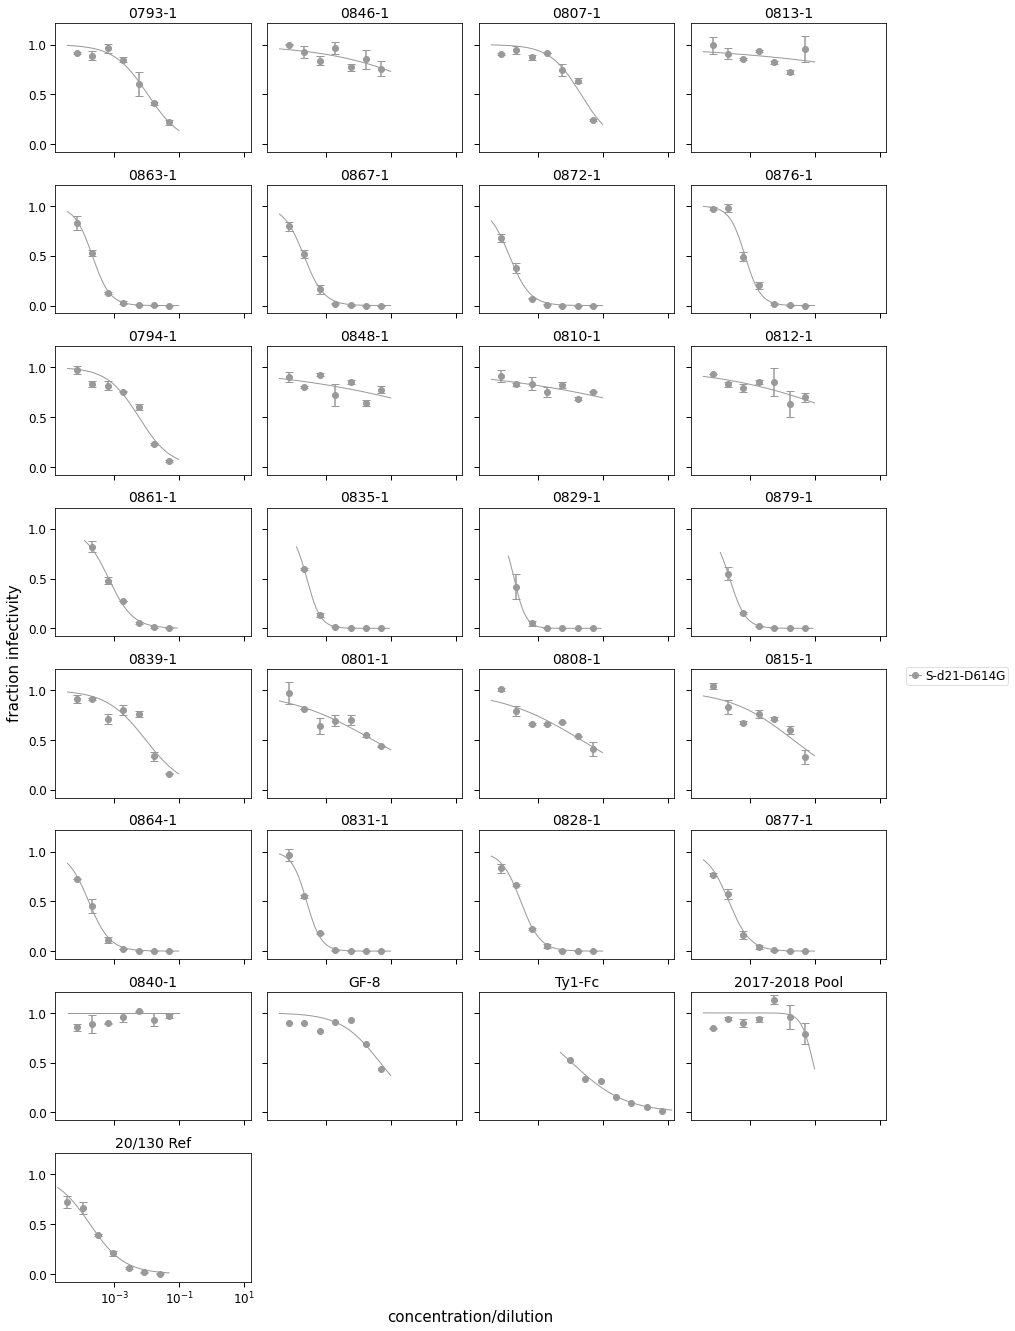

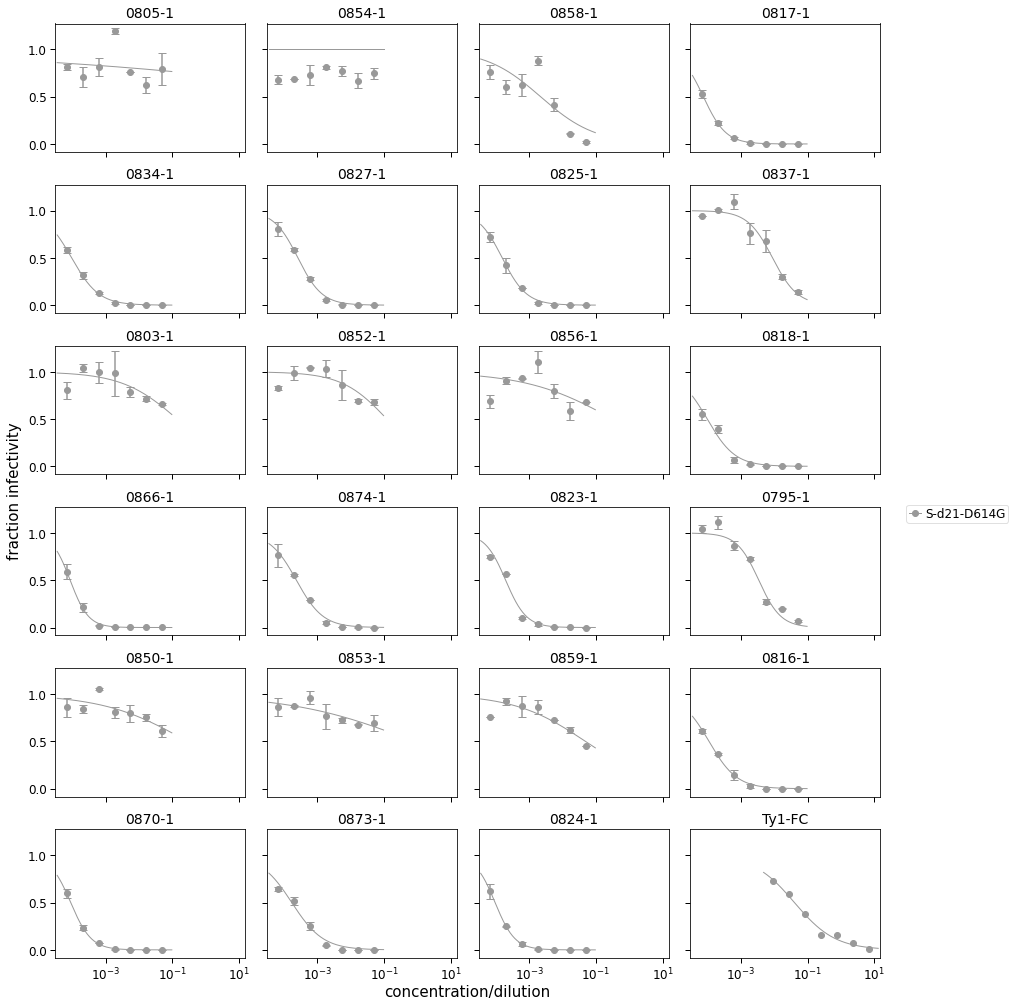

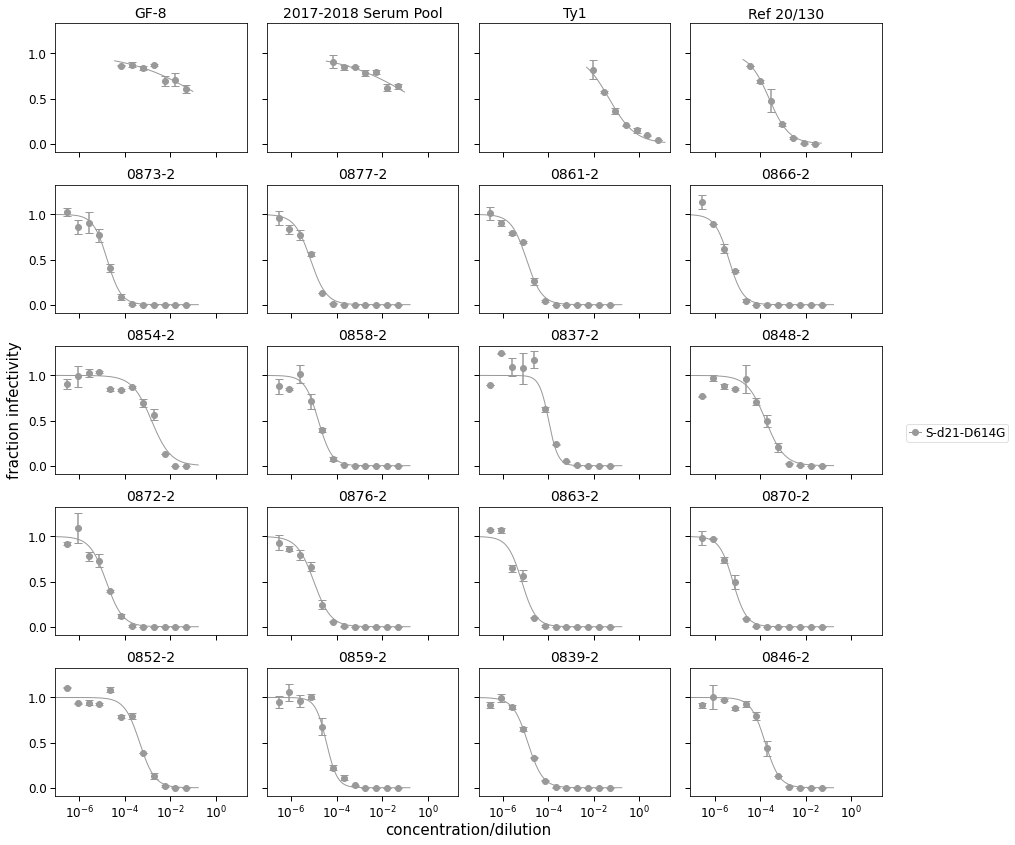

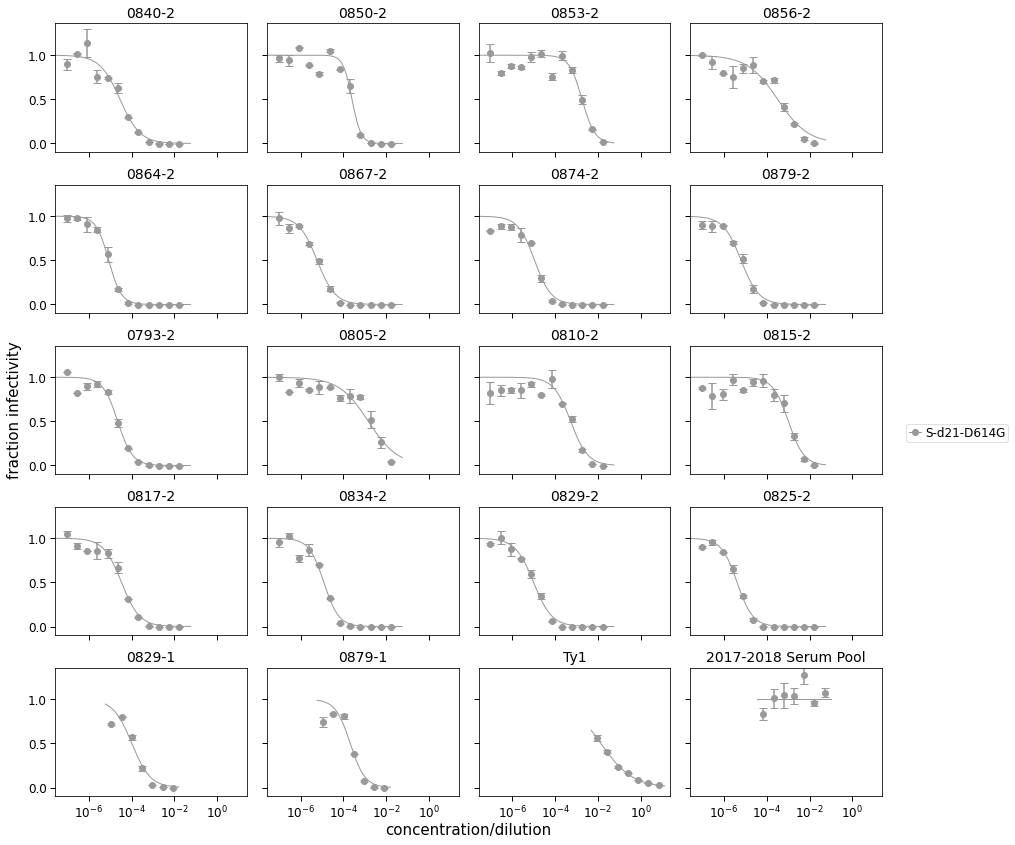

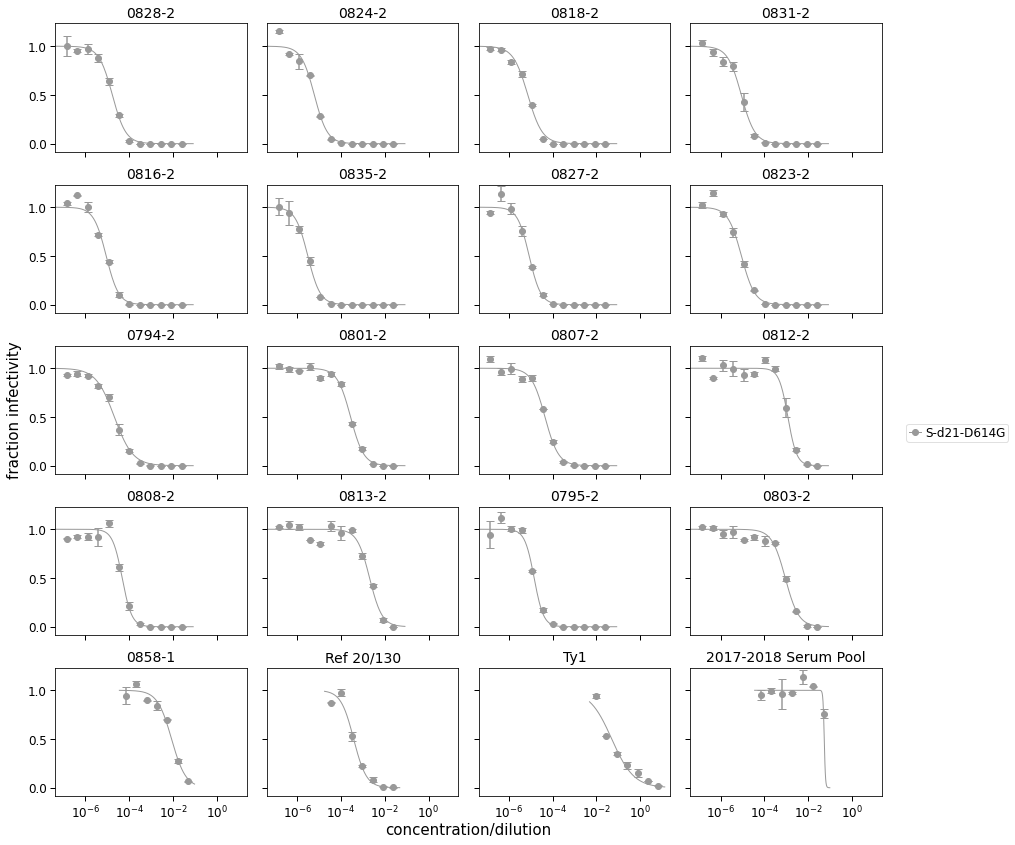

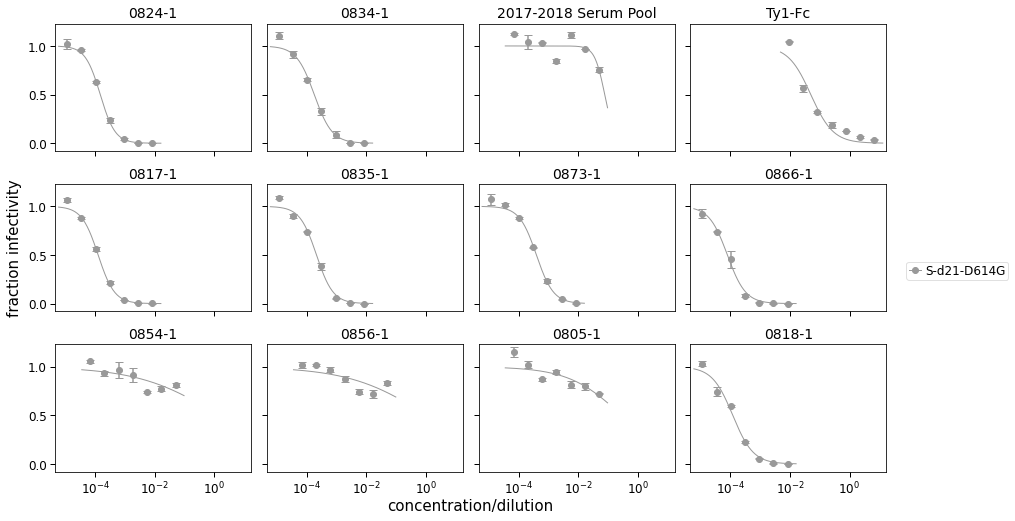

In [17]:
for rnd in fits.keys():
    fig, axes = fits[rnd].plotSera(xlabel='concentration/dilution')

## Plot Ty1-Fc control neut curves

The IC50 is 0.0108


/home/kdusenbu/.local/lib/python3.8/site-packages/numpy/core/_asarray.py:83: UserWarning: Warning: converting a masked element to nan.


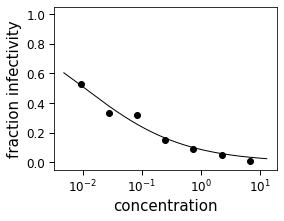

In [18]:
curve = fits['rnd1'].getCurve(serum='Ty1-Fc', virus='S-d21-D614G', replicate='1')
print(f"The IC50 is {curve.ic50():.3g}")
fig, ax = curve.plot()

The IC50 is 0.0405


/home/kdusenbu/.local/lib/python3.8/site-packages/numpy/core/_asarray.py:83: UserWarning: Warning: converting a masked element to nan.


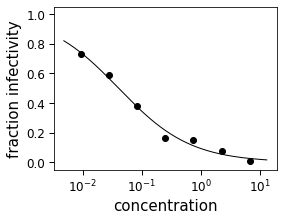

In [19]:
curve = fits['rnd2'].getCurve(serum='Ty1-FC', virus='S-d21-D614G', replicate='1')
print(f"The IC50 is {curve.ic50():.3g}")
fig, ax = curve.plot()

The IC50 is 0.0463


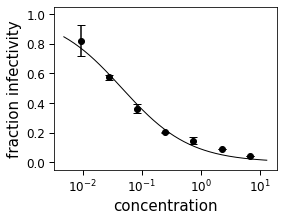

In [20]:
curve = fits['rnd3'].getCurve(serum='Ty1', virus='S-d21-D614G', replicate='average')
print(f"The IC50 is {curve.ic50():.3g}")
fig, ax = curve.plot()

The IC50 is 0.0137


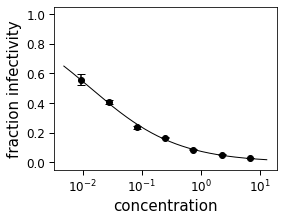

In [21]:
curve = fits['rnd4'].getCurve(serum='Ty1', virus='S-d21-D614G', replicate='average')
print(f"The IC50 is {curve.ic50():.3g}")
fig, ax = curve.plot()

The IC50 is 0.0497


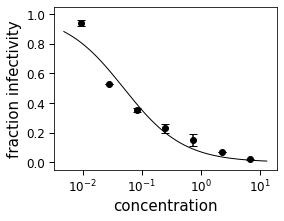

In [22]:
curve = fits['rnd5'].getCurve(serum='Ty1', virus='S-d21-D614G', replicate='average')
print(f"The IC50 is {curve.ic50():.3g}")
fig, ax = curve.plot()

The IC50 is 0.0501


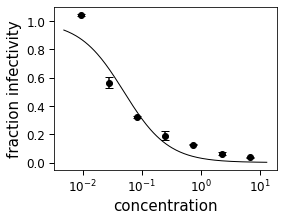

In [23]:
curve = fits['rnd6'].getCurve(serum='Ty1-Fc', virus='S-d21-D614G', replicate='average')
print(f"The IC50 is {curve.ic50():.3g}")
fig, ax = curve.plot()

The IC50 is 5.73e+03


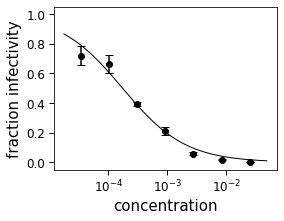

In [24]:
curve = fits['rnd1'].getCurve(serum='20/130 Ref', virus='S-d21-D614G', replicate='average')
print(f"The IC50 is {1/curve.ic50():.3g}")
fig, ax = curve.plot()

The IC50 is 4.02e+03


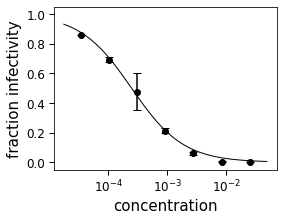

In [25]:
curve = fits['rnd3'].getCurve(serum='Ref 20/130', virus='S-d21-D614G', replicate='average')
print(f"The IC50 is {1/curve.ic50():.3g}")
fig, ax = curve.plot()

The IC50 is 2.63e+03


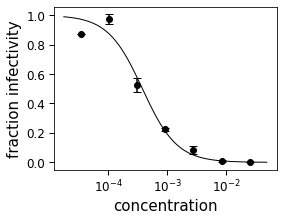

In [26]:
curve = fits['rnd5'].getCurve(serum='Ref 20/130', virus='S-d21-D614G', replicate='average')
print(f"The IC50 is {1/curve.ic50():.3g}")
fig, ax = curve.plot()

## Combine data into one df


In [27]:
all_data_df = pd.concat(fits_dfs)

## Drop Earlier Data for Samples that were re-run

Drop first sample and only keep re-run for samples that were re-run.

In [28]:
rerun = ['0829-1', '0879-1', '0858-1', '0854-1', '0856-1', '0805-1', '0818-1',
         '0817-1', '0835-1', '0873-1', '0866-1', '0824-1', '0834-1']

In [29]:
print(len(all_data_df))
drop_idxs = []
for sample in rerun:
    sample_data = all_data_df[all_data_df['serum']==sample]
    drop_idxs.append(sample_data['DateSetUp'].idxmin()) # drop earlier run

cleaned_data_df = all_data_df.drop(drop_idxs).reset_index(drop=True)
display(HTML(cleaned_data_df.head().to_html(index=False)))
print(len(cleaned_data_df))

126


serum,virus,replicate,nreplicates,ic50,ic50_bound,ic50_str,ic90,ic90_bound,ic90_str,midpoint,slope,top,bottom,nt50,nt90,DateSetUp,Plate,SampleNum
0793-1,S-d21-D614G,average,2,0.010629,interpolated,0.0106,0.050000,lower,>0.05,0.010629,0.831619,True,0.0,94.080392,20.000000,201013,Plate1,1
0846-1,S-d21-D614G,average,2,0.050000,lower,>0.05,0.050000,lower,>0.05,4.132835,0.265601,True,0.0,20.000000,20.000000,201013,Plate1,2
0807-1,S-d21-D614G,average,2,0.020702,interpolated,0.0207,0.050000,lower,>0.05,0.020702,0.903648,True,0.0,48.303432,20.000000,201013,Plate1,3
0813-1,S-d21-D614G,average,2,0.050000,lower,>0.05,0.050000,lower,>0.05,21279.859733,0.126899,True,0.0,20.000000,20.000000,201013,Plate1,4
0863-1,S-d21-D614G,average,2,0.000207,interpolated,0.000207,0.000825,interpolated,0.000825,0.000207,1.588156,True,0.0,4834.077623,1211.892515,201013,Plate2,1


113


### Output relevant data to csv

Output columns: `serum`, `ic50`, `ic90`, `nt50`, `nt90`, `DateSetUp`, `Plate`, `SampleNum`

In [30]:
export_df_all = all_data_df[['serum', 'ic50', 'ic90', 'nt50', 'nt90', 'DateSetUp', 'Plate', 'SampleNum']]
export_df_clean = cleaned_data_df[['serum', 'ic50', 'ic90', 'nt50', 'nt90', 'DateSetUp', 'Plate', 'SampleNum']]

# `all_neut_results` includes all neuts, including the first neuts
# from samples I reran and all controls.
export_df_all.to_csv('./all_neut_results.csv') 
# `mouse_plus_ctrls_neuts` only includes the later neuts for the
# samples I re-ran and all controls.
export_df_clean.to_csv('./mouse_plus_ctrls_neuts.csv')

## Initial Analyses

Only including re-runs for samples I ran twice.
Not including controls.

Export csv after adding timepoint and mouse data.

In [31]:
drop_samples = ['GF-8', 'Ref 20/130', '2017-2018 Serum Pool', '2017-2018 Pool', '20/130 Ref', '2017-2018 serum pool', 'Ty1', 'Ty1-FC', 'Ty1-Fc']
cleaned_data_df = cleaned_data_df[~cleaned_data_df['serum'].isin(drop_samples)].copy()
cleaned_data_df['Timepoint'] = cleaned_data_df['serum'].apply(lambda x: 'Prime' if '-1' in x else 'Boost')
cleaned_data_df['Mouse'] = cleaned_data_df['serum'].apply(lambda x: x[:-2])

In [32]:
display(HTML(cleaned_data_df.sort_values('Mouse').reset_index(drop=True).head().to_html(index=False)))

serum,virus,replicate,nreplicates,ic50,ic50_bound,ic50_str,ic90,ic90_bound,ic90_str,midpoint,slope,top,bottom,nt50,nt90,DateSetUp,Plate,SampleNum,Timepoint,Mouse
0793-1,S-d21-D614G,average,2,0.010629,interpolated,0.0106,0.050000,lower,>0.05,0.010629,0.831619,True,0.0,94.080392,20.000000,201013,Plate1,1,Prime,0793
0793-2,S-d21-D614G,average,2,0.000022,interpolated,2.24e-05,0.000128,interpolated,0.000128,0.000022,1.259974,True,0.0,44675.547272,7811.216903,201018,Plate5,1,Boost,0793
0794-2,S-d21-D614G,average,2,0.000021,interpolated,2.1e-05,0.000177,interpolated,0.000177,0.000021,1.030369,True,0.0,47596.830785,5642.361316,201019,Plate5,1,Boost,0794
0794-1,S-d21-D614G,average,2,0.005679,interpolated,0.00568,0.050000,lower,>0.05,0.005679,0.883053,True,0.0,176.078510,20.000000,201013,Plate3,1,Prime,0794
0795-2,S-d21-D614G,average,2,0.000014,interpolated,1.41e-05,0.000042,interpolated,4.18e-05,0.000014,2.028635,True,0.0,70698.442042,23934.448413,201019,Plate1,1,Boost,0795


In [33]:
groups = {'Group 1': ['0840', '0837', '0839', '0794', '0795', '0793'], 
          'Group 2': ['0801', '0803', '0805', '0850', '0848', '0846'],
          'Group 3': ['0808', '0807', '0810', '0853', '0854', '0852'],
          'Group 4': ['0813', '0812', '0815', '0856', '0858', '0859'],
          'Group 5': ['0816', '0818', '0817', '0864', '0861', '0863'],
          'Group 6': ['0835', '0831', '0834', '0867', '0866', '0870'],
          'Group 7': ['0827', '0828', '0829', '0874', '0873', '0872'],
          'Group 8': ['0823', '0824', '0825', '0879', '0877', '0876']}

In [34]:
cleaned_data_df["Group"] = cleaned_data_df["Mouse"].apply(lambda x: [group for group in groups.keys() if x in groups[group]][0])

In [35]:
display(HTML(cleaned_data_df.head().to_html(index=False)))

serum,virus,replicate,nreplicates,ic50,ic50_bound,ic50_str,ic90,ic90_bound,ic90_str,midpoint,slope,top,bottom,nt50,nt90,DateSetUp,Plate,SampleNum,Timepoint,Mouse,Group
0793-1,S-d21-D614G,average,2,0.010629,interpolated,0.0106,0.050000,lower,>0.05,0.010629,0.831619,True,0.0,94.080392,20.000000,201013,Plate1,1,Prime,0793,Group 1
0846-1,S-d21-D614G,average,2,0.050000,lower,>0.05,0.050000,lower,>0.05,4.132835,0.265601,True,0.0,20.000000,20.000000,201013,Plate1,2,Prime,0846,Group 2
0807-1,S-d21-D614G,average,2,0.020702,interpolated,0.0207,0.050000,lower,>0.05,0.020702,0.903648,True,0.0,48.303432,20.000000,201013,Plate1,3,Prime,0807,Group 3
0813-1,S-d21-D614G,average,2,0.050000,lower,>0.05,0.050000,lower,>0.05,21279.859733,0.126899,True,0.0,20.000000,20.000000,201013,Plate1,4,Prime,0813,Group 4
0863-1,S-d21-D614G,average,2,0.000207,interpolated,0.000207,0.000825,interpolated,0.000825,0.000207,1.588156,True,0.0,4834.077623,1211.892515,201013,Plate2,1,Prime,0863,Group 5


### Export csv of cleaned mouse neut data

Only includes latest run for samples I re-ran and doesn't include human serum (e.g. naive serum, ref serum or GF-8 sample) or Ty1-FC controls.

In [36]:
export_df_clean_noctrls = cleaned_data_df[['serum', 'ic50', 'ic90', 'nt50', 'nt90', 'DateSetUp', 'Plate', 'SampleNum', 'Timepoint', 'Mouse', 'Group']]
# `mouse_neuts` only includes the mouse neuts (no controls) and 
# only includes the later data for the samples I re-ran
export_df_clean_noctrls.to_csv('./mouse_neuts.csv')

### Initial plotting

In [37]:
group_list = ['Group 1', 'Group 2', 'Group 3', 'Group 4', 'Group 5',
              'Group 6', 'Group 7', 'Group 8']
group_cat = pd.Categorical(cleaned_data_df['Group'], categories=group_list)

tp_list = ['Prime', 'Boost']
tp_cat = pd.Categorical(cleaned_data_df['Timepoint'], categories=tp_list)

# assign to a new column in the DataFrame
cleaned_data_df = cleaned_data_df.assign(group_order = group_cat)
cleaned_data_df = cleaned_data_df.assign(timepoint_order = tp_cat)

/home/kdusenbu/.local/lib/python3.8/site-packages/plotnine/ggplot.py:727: PlotnineWarning: Saving 12 x 4 in image.
/home/kdusenbu/.local/lib/python3.8/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: ./NT50_plot.pdf


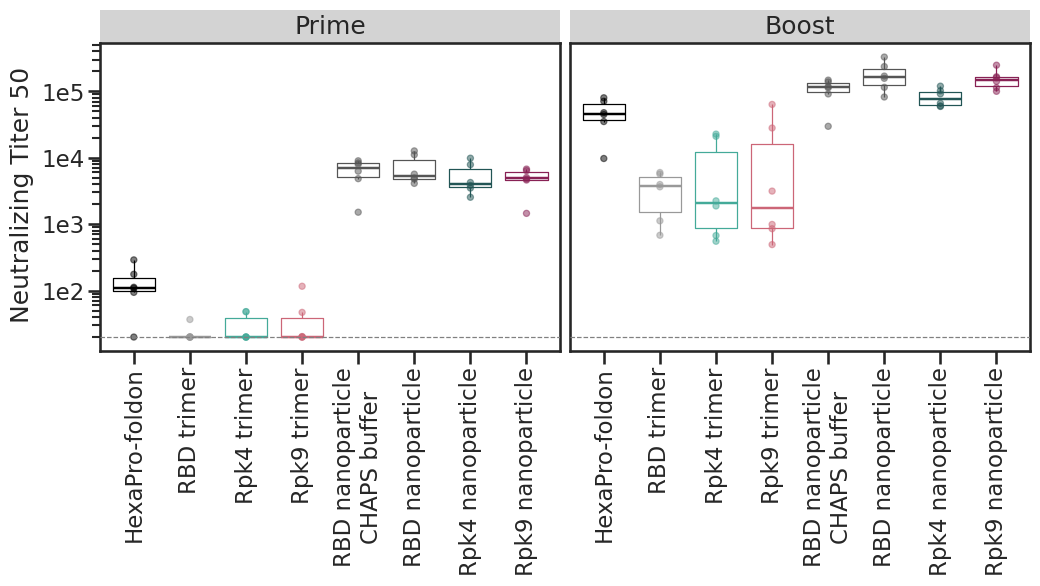

In [38]:
xlabs = ['HexaPro-foldon', 'RBD trimer', 'Rpk4 trimer', 'Rpk9 trimer', 'RBD nanoparticle\nCHAPS buffer', 'RBD nanoparticle', 'Rpk4 nanoparticle', 'Rpk9 nanoparticle']

# display(cleaned_data_df.columns)

ic50s_plot = (ggplot(cleaned_data_df, aes('group_order', 'nt50', color = 'group_order')) +
              geom_boxplot(outlier_alpha=0) +
              geom_point(size=2, alpha=0.5, position=position_dodge(width=0.75)) +
              scale_color_manual(values=['#000000', CBP[0], '#44AA99', '#CC6677', '#555555', '#555555', '#225555', '#882255'], guide=False) +
              theme(axis_text_x=element_text(angle=90, vjust=1, hjust=0.5),
                    figure_size=(12, 4)) +
              facet_wrap('~ timepoint_order') +
              geom_hline(yintercept=20, color='grey', linetype='dashed') +
              scale_y_continuous(trans='log10') +
#               labs(color='Timepoint') +
              scale_x_discrete(labels=xlabs) +
              xlab('') +
              ylab('Neutralizing Titer 50')
             )
fig.tight_layout()
ic50s_plot.save('./NT50_plot.pdf')

_ = ic50s_plot.draw()

### Convert to Markdown

In [39]:
!jupyter nbconvert MouseNeuts.ipynb --to markdown

[NbConvertApp] Converting notebook MouseNeuts.ipynb to markdown
[NbConvertApp] Support files will be in MouseNeuts_files/
[NbConvertApp] Making directory MouseNeuts_files
[NbConvertApp] Making directory MouseNeuts_files
[NbConvertApp] Making directory MouseNeuts_files
[NbConvertApp] Making directory MouseNeuts_files
[NbConvertApp] Making directory MouseNeuts_files
[NbConvertApp] Making directory MouseNeuts_files
[NbConvertApp] Making directory MouseNeuts_files
[NbConvertApp] Making directory MouseNeuts_files
[NbConvertApp] Making directory MouseNeuts_files
[NbConvertApp] Making directory MouseNeuts_files
[NbConvertApp] Making directory MouseNeuts_files
[NbConvertApp] Making directory MouseNeuts_files
[NbConvertApp] Making directory MouseNeuts_files
[NbConvertApp] Making directory MouseNeuts_files
[NbConvertApp] Making directory MouseNeuts_files
[NbConvertApp] Making directory MouseNeuts_files
[NbConvertApp] Writing 83683 bytes to MouseNeuts.md
